# Projeto NLP - Detectando Fake News (Noticias falsas)
Nesse projeto são apresentadas diferentes abordagens para detecção de noticias falsas.

# Motivação

No atual cenário de grande avanço tecnológico e uso das redes sociais em todas as camadas e classes sociais uma situação que causa problemas gráves é a divulgação de notícias falsas, pois essas podem prejucar a reputação de pessoas e organizações, e em casos mais gráves levar a linchamentos públicos.
Diante deste cenário, é de extrema importancia o desenvolvimento de métodos que consigam identificar possíveis noticias falsas para que seja possível tirá-las do ar.

Instalação das bibliotecas utilizadas

In [37]:
# !pip install -U scikit-learn
# !pip install pandas seaborn
# !pip install simpletransformers
# !pip install nltk
# !pip install tensorflow
# !pip install gensim

Importação das bibliotecas utilizaddas

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from datasets import load_dataset

from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils
import re
import string
import numpy as np

Configuração de display da biblioteca pandas

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.2f' %x)

# Lendo dados da base de dados 
<b>local de download:</b> Hugging faceFace

<b>url base 01:</b> https://huggingface.co/datasets/mrm8488/fake-news
<b>url base 02:</b> https://huggingface.co/datasets/fake_news_filipino

In [4]:
# Lendo os dados (base 01):
#with open('fake_news_data_set.json') as file:
#    data_set_json = json.load(file)
#
# Use pd.json_normalize to convert the JSON to a DataFrame
#df_news = pd.json_normalize(data_set_json['rows'], 
#                     meta=[['row', 'text'], ['row', 'label']])

df_news = load_dataset("mrm8488/fake-news")
df_news = pd.DataFrame(df_news['train'])

df_news.head()

,text,label
0,The Trump administration has been getting abso...,1
1,NAIROBI (Reuters) - Kenyan police shot dead tw...,0
2,PC is killing our country. This is called figh...,1
3,WASHINGTON (Reuters) - Republicans are poised ...,0
4,(Reuters) - A U.S. appeals court ruled on Frid...,0


In [5]:
# Detalhes da base
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [6]:
# Colunas da base de dados
df_news.columns

Index(['text', 'label'], dtype='object')

In [7]:
# Validando a existência de dados nulos, no caso não existe
df_news.isnull().sum()

text     0
label    0
dtype: int64

In [8]:
# Validando a existência de dados na, no caso não existe
df_news.isna().sum()

text     0
label    0
dtype: int64

In [9]:
# Rótulos dos dados 0 - Notícia Real, 1 - Notícia falsa
df_news['label'].unique()

array([1, 0])

<Axes: xlabel='label', ylabel='count'>

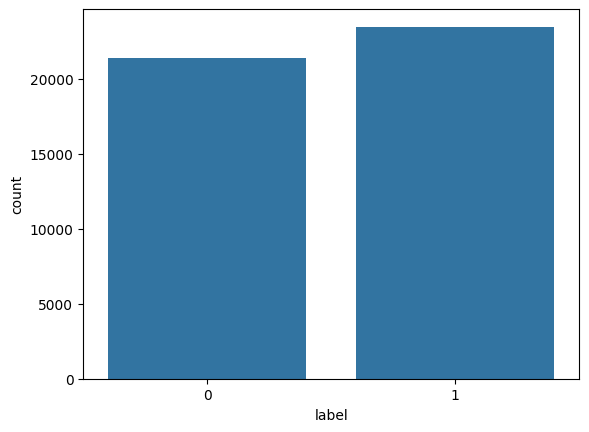

In [10]:
# Distribuição de positivos e negativos
sns.countplot(data=df_news, x='label')

Podemos observar que a base tem uma boa distribuição entre positivos e negativos, aproximadamente 50% para cada label.

# Preparando base para treinamento dos modelos
Separação em features e target

In [107]:
# Separando as features X e Y, treianemnto e teste
X = df_news['text']
Y = df_news['label']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=42)

# Tokenization
Criando uma representação para o texto por meio de p método TFiDF

In [12]:
# Download de stopwords para limpeza de ruidos
nltk.download('stopwords')
sw_en = nltk.corpus.stopwords.words('english')
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=sw_en)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/williansmagalhaesprimo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Aplicando a tokenização na base de treinamento
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf.shape

(35918, 65667)

# Modelo de NLP 01 - SVC
Nessa primeira abordagem será usado o SVC <b>Modelo de Linear Support Vector Classifier</b>.
Uma versão do SVN - Suport Vector Machine aplicado em tarefas de classificação

In [14]:
# Criação do modelo SVC:
svc = LinearSVC()
svc.fit(X_train_tfidf, y_train)

/Users/williansmagalhaesprimo/Library/Python/3.8/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [15]:
# Aplicando a tokenização na base de test
X_test_tfidf = vectorizer.transform(X_test)
X_test_tfidf.shape

(8980, 65667)

Testes e Métricas para o modelo SVC

In [16]:
# Teste do modelo SVC
prediction = svc.predict(X_test_tfidf)

# Verificando acurácia do modelo SVC
accuracy = accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)

Accuracy: 0.9942093541202672


In [17]:
# Métricas para o modelo SVC (scores)
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4271
           1       0.99      0.99      0.99      4709

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



<Axes: >

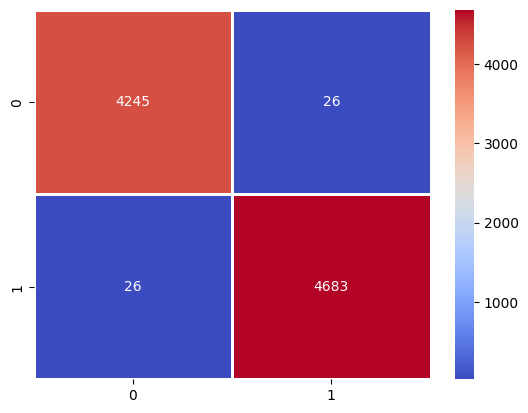

In [18]:
# Matriz de confusão
matriz_svc = metrics.confusion_matrix(y_test, prediction)
sns.heatmap(matriz_svc, cmap='coolwarm', annot=True, linewidth=1, fmt='d')

Como podemos ver, utilizando o modelo SVC jutamente com o método TFiDF apresentou um bom resultado, e com um equilibrio entre falsos positivos e falsos negativos.

# Modelo NLP 02 - Redes Neurais - feedforward (Sequencial)
Nessa segunda abordagem, iremos utilizar uma Rede neural Sequencial

In [19]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=sw_en)
# Aplicando a tokenização na base de treinamento
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf = X_train_tfidf.toarray()
X_train_tfidf.shape

(35918, 65667)

In [20]:
# Criando o modelo de Rede Neural
# Tamanho da entrada
input_size = X_train_tfidf.shape[1]
net = keras.Sequential()
net.add(layers.Dense(32, input_shape=(input_size,)))
net.add(layers.Dropout(.2))
net.add(layers.Dense(16, activation = 'tanh'))
net.add(layers.Dense(1, activation = 'sigmoid'))
print(net.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2101376   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2101921 (8.02 MB)
Trainable params: 2101921 (8.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [21]:
# Compilando o modelo de Rede Neural 
net.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=["accuracy"],
)

In [22]:
# Treino do modelo
net.fit(X_train_tfidf, y_train, batch_size=16, epochs=2)

Epoch 1/2
2245/2245 [==============================] - 52s 23ms/step - loss: 0.0659 - accuracy: 0.9813
Epoch 2/2
2245/2245 [==============================] - 51s 23ms/step - loss: 0.0039 - accuracy: 0.9991


In [23]:
# Aplicando a tokenização na base de teste
X_test_tfidf = vectorizer.transform(X_test).toarray()
X_test_tfidf.shape

(8980, 65667)

In [27]:
# Teste do modelo Rede Neural
#prediction = net.evaluate(X_test_tfidf, y_test, batch_size = 1)
prediction = net.predict(X_test_tfidf)
prediction = [0 if p < 0.5 else 1 for p in prediction]
# Verificando acurácia do modelo Rede Neural
accuracy = accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)

281/281 [==============================] - 1s 4ms/step
Accuracy: 0.9927616926503341


In [25]:
# Métricas para o modelo Rede Neural (scores)
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4271
           1       1.00      0.99      0.99      4709

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



<Axes: >

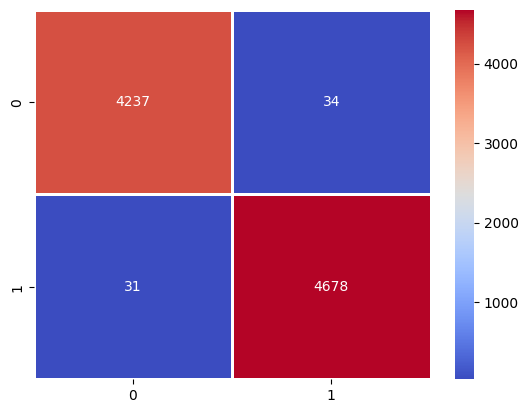

In [28]:
# Matriz de confusão
matriz_net = metrics.confusion_matrix(y_test, prediction)
sns.heatmap(matriz_net, cmap='coolwarm', annot=True, linewidth=1, fmt='d')

Com a utilização de uma Rede Neural Feedfoward também observa-se um bom desempenho. Uma matriz de confusão equilibrada entre acertos, erros falsos positivos e falsos negativos.

# Utilizando uma segunda base de dados para testes
Como foi utilizada uma base de dados pequena, aparentemente o modelo está apresentando overfiting, para validar essa possibilidade optou-se por usar uma segunda base apenas para teste e validar o grau de acerto e generalização do modelo.

In [138]:
# Lendo os dados (base 02):
df_news_02 = load_dataset("fake_news_filipino")
df_news_02 = pd.DataFrame(df_news_02['train'])

df_news_02.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


<Axes: xlabel='label', ylabel='count'>

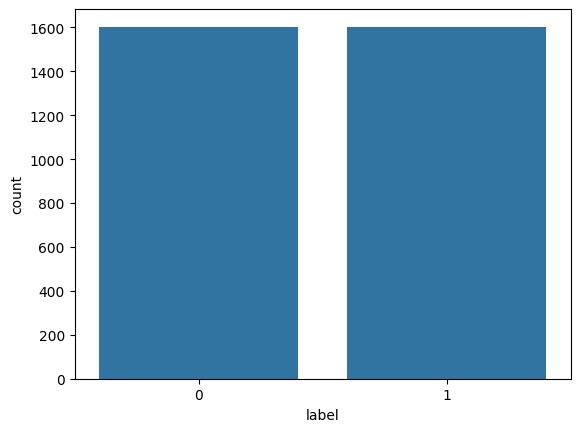

In [142]:
# Distribuição de positivos e negativos
sns.countplot(data=df_news_02, x='label')

In [139]:
# Aplicando a tokenização na base de teste 2
X_test_base_02 = df_news_02['article']
y_test_base_02 = df_news_02['label']
X_test_tfidf = vectorizer.transform(X_test_base_02).toarray()
X_test_tfidf.shape

(3206, 65667)

In [33]:
# Teste do modelo Rede Neural - Base 02
prediction = net.predict(X_test_tfidf)
prediction = [0 if p < 0.5 else 1 for p in prediction]
# Verificando acurácia do modelo Rede Neural
accuracy = accuracy_score(y_test_base_02, prediction)
print("Accuracy:", accuracy)

101/101 [==============================] - 0s 3ms/step
Accuracy: 0.5074859638178415


In [34]:
# Métricas para o modelo Rede Neural (scores)
print(metrics.classification_report(y_test_base_02, prediction))

              precision    recall  f1-score   support

           0       0.72      0.02      0.05      1603
           1       0.50      0.99      0.67      1603

    accuracy                           0.51      3206
   macro avg       0.61      0.51      0.36      3206
weighted avg       0.61      0.51      0.36      3206



<Axes: >

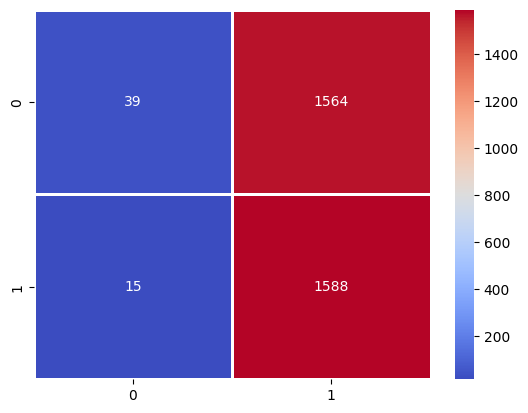

In [35]:
# Matriz de confusão
matriz_net = metrics.confusion_matrix(y_test_base_02, prediction)
sns.heatmap(matriz_net, cmap='coolwarm', annot=True, linewidth=1, fmt='d')

# Observação
Mesmo obtendo bons resultados em uma base específica sobre fakenews, o modelo de redes neurais não conseguiu generalizar para outros casos. Podemos ter duas situações nesse caso: 1 - dificuldade de generalização por parte de uma Rede Neural sequêncial (Feedforward Neural Network), ou as fake news não apresentam uma estrutura própria, sendo que a classificação desse tipo de desinformação depende muito do contexto onde é aplicada.

## Testes utilizando Doc2Vec
A seguir será utilizada um método diferente para codificação da entrada para a rede, no caso será utilizado o mérodo Doc2Vec

In [58]:
# Funções para limpeza do texto
def constructLabeledSentences(data):
    sentences=[]
    for index, row in enumerate(data):
        sentences.append(TaggedDocument(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text


In [129]:
# Aplicando doc2Vec na base
model_size = 256
X_train_d2v = [cleanup(s) for s in X_train]
X_sentenses_d2v = constructLabeledSentences(X_train_d2v)
d2v = Doc2Vec(vector_size=model_size, min_count=2, epochs=5)
d2v.build_vocab(X_sentenses_d2v)
d2v.train(X_sentenses_d2v, total_examples=d2v.corpus_count, epochs=d2v.epochs)

In [130]:
# Aplicando doc2vec na base de teste
X_train_d2v = [d2v.infer_vector(s.split()) for s in X_train_d2v]
X_train_d2v = np.array([[c for c in l] for l in X_train_d2v])
X_train_d2v

array([[-0.05451417, -0.14314115, -0.20658155, ..., -0.21861546,
        -0.04384064,  0.0036475 ],
       [-0.09873001, -0.11078482, -0.17677914, ..., -0.42887843,
         0.05289656, -0.09938983],
       [-0.33894414, -0.0450299 , -0.5288748 , ..., -0.30410278,
         0.08878949,  0.01572632],
       ...,
       [-0.00959712, -0.02895845,  0.01040759, ..., -0.13496573,
        -0.02056548, -0.10905641],
       [-0.45543334,  0.018041  , -0.11652192, ..., -0.164463  ,
        -0.19055063,  0.2433371 ],
       [ 0.39617917, -0.01762554, -0.39493605, ..., -0.02289576,
        -0.1918172 ,  0.12270238]], dtype=float32)

In [147]:
# Criando o modelo de Rede Neural
net = keras.Sequential()
net.add(layers.Dense(128, input_shape=(model_size,)))
net.add(layers.Dropout(.2))
net.add(layers.Dense(64, activation = 'tanh'))
net.add(layers.Dense(1, activation = 'sigmoid'))
print(net.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 41217 (161.00 KB)
Trainable params: 41217 (161.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None


In [149]:
# Compilando o modelo de Rede Neural 
net.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=["accuracy"],
)
# Treino do modelo
net.fit(X_train_d2v, y_train, batch_size=4, epochs=10)

Epoch 1/10
8980/8980 [==============================] - 10s 1ms/step - loss: 0.1709 - accuracy: 0.9325
Epoch 2/10
8980/8980 [==============================] - 9s 1ms/step - loss: 0.1677 - accuracy: 0.9334
Epoch 3/10
8980/8980 [==============================] - 9s 1ms/step - loss: 0.1636 - accuracy: 0.9352
Epoch 4/10
8980/8980 [==============================] - 9s 1ms/step - loss: 0.1592 - accuracy: 0.9373
Epoch 5/10
8980/8980 [==============================] - 9s 1ms/step - loss: 0.1553 - accuracy: 0.9380
Epoch 6/10
8980/8980 [==============================] - 9s 1ms/step - loss: 0.1537 - accuracy: 0.9395
Epoch 7/10
8980/8980 [==============================] - 10s 1ms/step - loss: 0.1499 - accuracy: 0.9403
Epoch 8/10
8980/8980 [==============================] - 9s 1ms/step - loss: 0.1496 - accuracy: 0.9418
Epoch 9/10
8980/8980 [==============================] - 9s 1ms/step - loss: 0.1483 - accuracy: 0.9421
Epoch 10/10
8980/8980 [==============================] - 10s 1ms/step - loss: 0.

In [150]:
# Aplicando doc2vec na base de teste
X_test_d2v = [cleanup(s) for s in X_test]
X_test_d2v = [d2v.infer_vector(s.split()) for s in X_test_d2v]
X_test_d2v = np.array([[c for c in l] for l in X_test_d2v])
X_test_d2v

array([[ 0.13396692, -0.15779254, -0.1456717 , ..., -0.16906215,
        -0.09483577,  0.03456771],
       [ 0.19894442, -0.3619321 , -0.02470553, ...,  0.05216229,
         0.02681638, -0.13039295],
       [ 0.07030161, -0.2505194 , -0.15465787, ..., -0.1508473 ,
         0.03851219, -0.0695099 ],
       ...,
       [-0.01898931, -0.13697278, -0.13316382, ..., -0.1793206 ,
        -0.22463952,  0.05944481],
       [ 0.06560505, -0.0916406 , -0.01887669, ..., -0.07860537,
        -0.03362177, -0.01876862],
       [ 0.01807131,  0.25632772, -0.35085997, ..., -0.63319224,
        -0.11480427, -0.19409174]], dtype=float32)

In [135]:
# Teste do modelo Rede Neural
prediction = net.predict(X_test_d2v)
prediction = [0 if p < 0.5 else 1 for p in prediction]
# Verificando acurácia do modelo Rede Neural
accuracy = accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)

281/281 [==============================] - 0s 745us/step
Accuracy: 0.9326280623608018


In [151]:
# Aplicando doc2vec na base de teste (2)
X_test_d2v = [cleanup(s) for s in X_test_base_02]
X_test_d2v = [d2v.infer_vector(s.split()) for s in X_test_d2v]
X_test_d2v = np.array([[c for c in l] for l in X_test_d2v])
X_test_d2v

array([[-0.18204273, -0.31884527,  0.08380374, ..., -0.19789591,
        -0.04070776, -0.18326831],
       [-0.06716754, -0.16752878,  0.02587237, ..., -0.09555168,
        -0.10310234, -0.07429661],
       [ 0.03935201, -0.05982582, -0.08404344, ..., -0.08678329,
        -0.03031185, -0.02584643],
       ...,
       [-0.02697368, -0.11061934, -0.04479908, ..., -0.06033918,
        -0.08193562, -0.00771785],
       [ 0.03111349, -0.22766636,  0.02051973, ..., -0.05397316,
        -0.06101232, -0.03485818],
       [-0.13354142, -0.19680466, -0.02367832, ..., -0.08565547,
        -0.04758109,  0.01155206]], dtype=float32)

In [157]:
# Teste do modelo Rede Neural para a base (2)
prediction = net.predict(X_test_d2v)
prediction = [0 if p < 0.5 else 1 for p in prediction]
# Verificando acurácia do modelo Rede Neural
accuracy = accuracy_score(y_test_base_02, prediction)
print("Accuracy:", accuracy)

101/101 [==============================] - 0s 798us/step
Accuracy: 0.48533998752339363


# Conclusão final
Mesmo com a utilização de diferentes técnicas o modelo de Rede neural não conseguil se ajustar para ter uma bom resultado em uma base diferente da que foi treinada, com isso é possível perceber que a tarefa de classificação de fakenews, pode ser um grande desafio, pois aparentemente ou você precisa de uma base muito diversa para treinar o modelo ou então os modelos serão efetivos apenas em aplicações específicas para as quais foram treinadas.